In [22]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

In [ ]:
# HYPERPARAMETERS
EPOCHS = 10
INPUT_SHAPE = (7, 7, 512)

In [41]:
from keras.applications.vgg16 import VGG16
'''
Cloning pre-trained classification model: VGG16
We will utilize the encoding layers and discard fully connected layers.
Acts as encoder for the auto-encoder colorization algorithm.

https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16

relevant params:
    include_top	
        whether to include the 3 fully-connected layers at the top of the network.
    input_shape	
        optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with channels_last data format) or (3, 224, 224) (with "channels_first" data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.
    pooling	
        Optional pooling mode for feature extraction when include_top is False.
'''
vggmodel = VGG16(include_top=False)
vggmodel.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
'''
Don't want to train these layers again, so freeze 'em
'''
for layer in vggmodel.layers:
  layer.trainable=False   

In [40]:
'''
Define decoder
'''
model = Sequential([Input(shape=(7, 7, 512))])

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 2)    │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 224, 224, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,114 (6.00 MB)

 Trainable params: 1,572,114 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train() -> None:
    None

In [14]:
'''
Create dataloader from director path
''' 
path = 'images/'

# Load normalized rgb images - divide by 255
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
# Create training data flow
train = datagen.flow_from_directory(path, batch_size=32, class_mode=None)

train

Found 1 images belonging to 1 classes.


In [21]:
train_l =[]
val_ab =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      train_l.append(lab[:,:,0]) 
      val_ab.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
train_l = np.array(train_l)
val_ab = np.array(val_ab)
train_l = train_l.reshape(train_l.shape+(1,)) #dimensions to be the same for X and Y
print(train_l.shape)
print(val_ab.shape)
display(Image(train_l[0]))

(1, 256, 256, 1)
(1, 256, 256, 2)


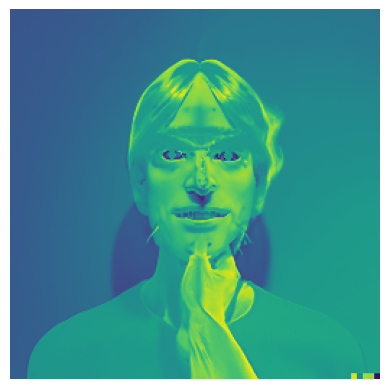

array([[[49.023857],
        [49.047684],
        [48.744102],
        ...,
        [65.82622 ],
        [65.6897  ],
        [65.651436]],

       [[48.966476],
        [49.031807],
        [49.031807],
        ...,
        [65.490204],
        [66.131775],
        [65.82622 ]],

       [[49.023857],
        [49.03975 ],
        [49.359383],
        ...,
        [66.26929 ],
        [65.82622 ],
        [65.82622 ]],

       ...,

       [[42.24537 ],
        [42.98431 ],
        [43.044216],
        ...,
        [42.089497],
        [42.089497],
        [42.089497]],

       [[42.18662 ],
        [42.214657],
        [42.956234],
        ...,
        [42.089497],
        [42.089497],
        [42.089497]],

       [[42.100857],
        [42.243446],
        [42.926598],
        ...,
        [42.089497],
        [42.089497],
        [42.089497]]], dtype=float32)

In [36]:
import matplotlib.pyplot as plt

# Load and display an image
img = val_ab[0][:,:,1]
# img = val_ab[0][:,:,0]
# img = train_l[0]
plt.imshow(img) ## add param for grayscale: cmap='gray'  ##
plt.axis('off')  # Hide the axis
plt.show()

train_l[0]


In [1]:
import create_video as cc

frames = cc.process_video_frames('./videos/')


Processing barbie.mp4...
Finished processing barbie.mp4. Exiting ...


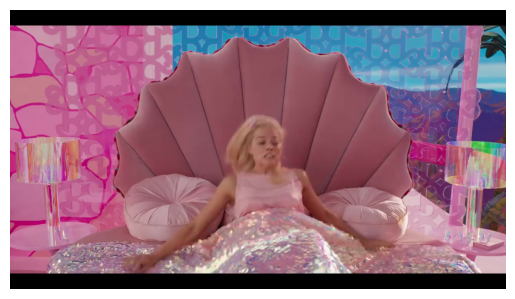

(720, 1280, 3)


In [5]:
import matplotlib.pyplot as plt

img = frames[1020][0]
plt.imshow(img) ## add param for grayscale: cmap='gray'  ##
plt.axis('off')  # Hide the axis
plt.show()
print(img.shape)